<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
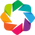

In [2]:
import pystac_client
import folium
from odc import stac as odc_stac
from ascat.read_native.ragged_array_ts import CellFileCollection
import xarray as xr
from pathlib import Path
import numpy as np
from pyproj import Transformer
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import yaml
import holoviews as hv
import dask
import zarr         #new

dask.config.set(**{"array.slicing.split_large_chunks": True})

hv.extension("bokeh")
import hvplot.xarray

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    # h121_ds = h121_ds.set_index(time="time")

### Loading Sentinel - 1 Sigma Naught Data from EODC STAC Catalogue

In [3]:
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")

colllection_id = "SENTINEL1_SIG0_20M"

collection = eodc_catalog.get_collection(colllection_id)

Setting time and area of interest.

In [4]:
time_range ="2021-01-01/2021-01-05" # "2021-01-01/2023-12-31"

latmin, latmax = 30.0, 45.0            # South to North
lonmin, lonmax = -10.0, 5.0            # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]

Loading the metadata with STAC search engine.

In [5]:
search = eodc_catalog.search(
    collections=colllection_id,
    bbox=bounding_box,
    datetime=time_range,
    # max_items=1  # number of max items to load
)
items_eodc = search.item_collection()
print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 479 items for the given search query


Let's plot thumbnail of the loaded items for this area and those dates.

In [54]:
# better dont run this
map = folium.Map(
    location=[(latmin + latmax) / 2, (lonmin + lonmax) / 2],
    zoom_start=7,
    zoom_control=False,
    scrollWheelZoom=False,
    dragging=False,
)

folium.Rectangle(
    bounds=[[latmin, lonmin], [latmax, lonmax]],
    color="blue",
    fill=True,
    fill_opacity=0.1,
    weight=2,
    popup="Area of Interest",
).add_to(map)

for item in items_eodc:
    # url leading to display of an item, can also be used as hyperlink
    image_url = item.assets["thumbnail"].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
    ).add_to(map)

folium.LayerControl().add_to(map)

map

To lower the storage space substantially we want to lower the resolution from 20m to 12.5km. 
Steps to take:

- Moasik pices form the same swath together before we do resampling


Actual work:

- db to linear

- resample from 20m to 6.25km in the Equi7 Grid
- do the projection to FibGrid (grid remapping)
- use nearest neighbour to go to 12.5km (align with the ASCAT data)

- linear back to db


### and now make it fast

In [ ]:
from pathlib import Path
import numpy as np

def _preprocess(x, scale, nodata):
    
    # Mask no-data values
    x = x.where(x != nodata, np.nan)

    # Apply scaling
    x = x * scale

    return x

In [ ]:
crs = "EPSG:27704"  # Coordinate Reference System: EQUI7 Grid of Europe
res =  20 # resampling to larger resulution should not be done for db data

nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

chunks = {"time": 1, "latitude": 1000, "longitude": 1000}
sig0_dc = odc_stac.load(
    items_eodc,
    crs=crs,
    resolution=res,
    bbox=bounding_box,
    chunks=chunks,
    preprocess=lambda x: _preprocess(x, scale, nodata),
    resampling="bilinear",
)
sig0_dc

<xarray.Dataset> Size: 7TB
Dimensions:      (y: 102638, x: 89514, time: 192)
Coordinates:
  * y            (y) float64 821kB 1.844e+06 1.844e+06 ... -2.09e+05 -2.09e+05
  * x            (x) float64 716kB 2.56e+06 2.56e+06 ... 4.35e+06 4.35e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 2kB 2021-01-01T05:28:32 ... 2021-01-05...
Data variables:
    VH           (time, y, x) int16 4TB dask.array<chunksize=(1, 102638, 89514), meta=np.ndarray>
    VV           (time, y, x) int16 4TB dask.array<chunksize=(1, 102638, 89514), meta=np.ndarray>

Lets list the commands I want to execute and then get feedback on this approach:

In [ ]:
sig0_dc_linear = 10 ** (sig0_dc / 10)                                        # use functions?

sig0_dc_linear_hourly = sig0_dc_linear.resample(time="1H").mean(dim="time")  # one hour is good
                                                                            
# --
sig_dc_linear_6p25 = sig0_dc_linear_hourly.coarsen(x=312.5, y=312.5).mean()  # from 20m to 6.25km 
                                                                             # here think of the gridpoints
                                                                             # -> should they start to align with the ASCAT data?

sig_dc_linear_6p25_filled = sig_dc_linear_6p25.ffill(dim = "time")

sig_dc_6p25 = 10 * np.log10(sig_dc_linear_6p25_filled)

sig_dc_6p25.to_zarr()




# do i need to make my own implementation?

sig_dc_linear_6p25_fibgrid = 
sig_dc_linear_12p5_fibgrid = sig_dc_linear_6p25_fibgrid.nearest.neighbour
# or straight away
sig_dc_linear_12p5_fibgrid = 
# --

# or we use:

#but this does not work:
#sig_dc_linear_12p5_fibgrid = sig0_dc_linear_hourly.rio.reproject_match(ASCAT_data, resampling = "bilinear" ) # only for raster data


sig_dc_12p5_fibgrid = 10 * np.log10(sig_dc_linear_12p5_fibgrid)
sig_dc_12p5_fibgrid

ValueError: freq must be an object of type 'str', 'datetime.timedelta', 'pandas.Timedelta', 'pandas.DateOffset', or 'TimeResampler'. Received <class 'float'> instead.

Why is it ok to use the equi7 grid of europe?
- should be ok because the grid spanns a little bit into aftica and we only use a small piece in the north west of africa

### Test the resample
Documentation can be found under https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html.

In [ ]:
# testing the resampling for a smaller resolution:

crs = "EPSG:27704"  # Coordinate Reference System: EQUI7 Grid of Europe
res =  12500        # resampling to larger resulution should not be done for db data
nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

chunks = {"time": 1, "latitude": 1000, "longitude": 1000}
sig0_dc_for_plotting = odc_stac.load(
    items_eodc,
    crs=crs,
    resolution=res, # bad practice as this is db data
    bbox=bounding_box,
    chunks=chunks,
    preprocess=lambda x: _preprocess(x, scale, nodata),
    resampling="bilinear",
)

sig0_dc_for_plotting

<xarray.Dataset> Size: 18MB
Dimensions:      (y: 165, x: 145, time: 192)
Coordinates:
  * y            (y) float64 1kB 1.844e+06 1.831e+06 ... -1.938e+05 -2.062e+05
  * x            (x) float64 1kB 2.556e+06 2.569e+06 ... 4.344e+06 4.356e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 2kB 2021-01-01T05:28:32 ... 2021-01-05...
Data variables:
    VH           (time, y, x) int16 9MB dask.array<chunksize=(1, 165, 145), meta=np.ndarray>
    VV           (time, y, x) int16 9MB dask.array<chunksize=(1, 165, 145), meta=np.ndarray>

In [14]:
sig0_dc_for_plotting = sig0_dc_for_plotting.isel(time=range(20)).compute()
sig0_dc_for_plotting

c:\Users\jwagner\AppData\Local\anaconda3\envs\ascat-s1-synergy\lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
c:\Users\jwagner\AppData\Local\anaconda3\envs\ascat-s1-synergy\lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


<xarray.Dataset> Size: 2MB
Dimensions:      (y: 165, x: 145, time: 20)
Coordinates:
  * y            (y) float64 1kB 1.844e+06 1.831e+06 ... -1.938e+05 -2.062e+05
  * x            (x) float64 1kB 2.556e+06 2.569e+06 ... 4.344e+06 4.356e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 160B 2021-01-01T05:28:32 ... 2021-01-0...
Data variables:
    VH           (time, y, x) int16 957kB -9999 -9999 -9999 ... -9999 -9999
    VV           (time, y, x) int16 957kB -9999 -9999 -9999 ... -9999 -9999

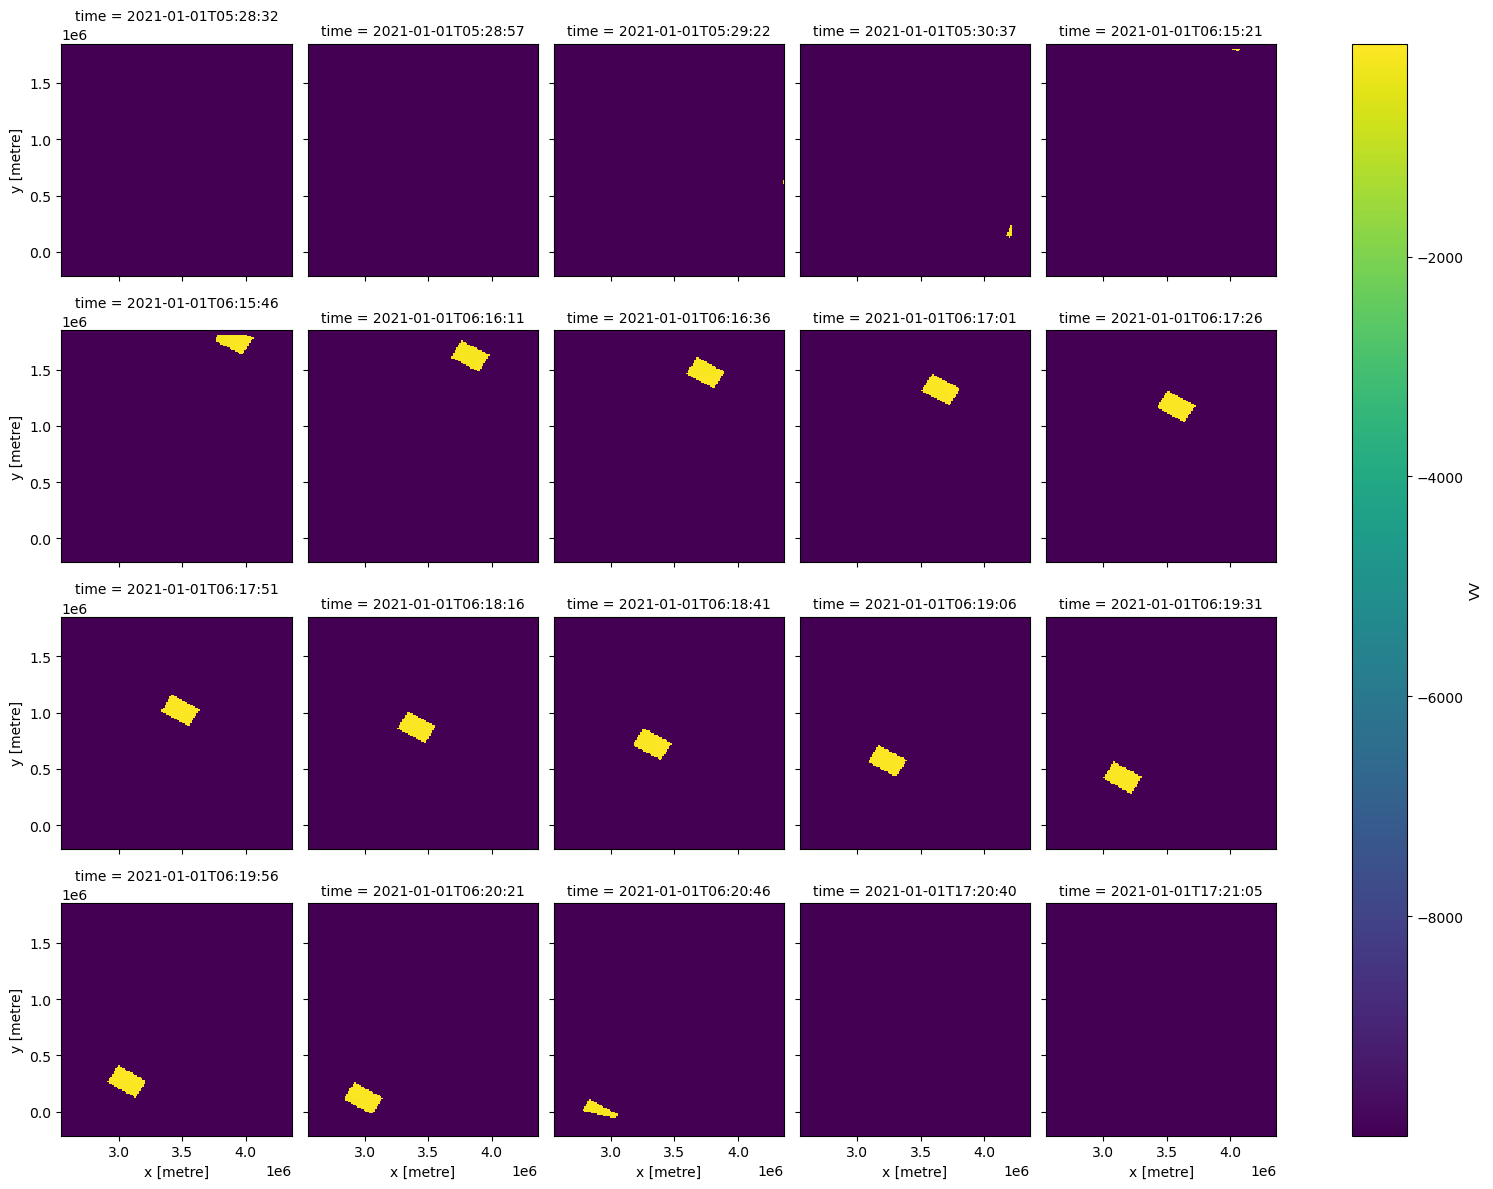

In [21]:
sig0_dc_for_plotting.VV.plot.imshow(col="time", col_wrap=5)

In [ ]:
#sig0_dc.resample(x=625, y=625, time="1H").mean()   
sig0_dc_for_plotting_daily = sig0_dc_for_plotting.resample(time="1D").mean(dim='time')  # dont take the NAs into account
sig0_dc_for_plotting_daily
# lin2db(db2lin) should be used to create the correct mean but from where?

<xarray.Dataset> Size: 385kB
Dimensions:      (time: 1, y: 165, x: 145)
Coordinates:
  * y            (y) float64 1kB 1.844e+06 1.831e+06 ... -1.938e+05 -2.062e+05
  * x            (x) float64 1kB 2.556e+06 2.569e+06 ... 4.344e+06 4.356e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 8B 2021-01-01
Data variables:
    VH           (time, y, x) float64 191kB -9.999e+03 -9.999e+03 ... -9.999e+03
    VV           (time, y, x) float64 191kB -9.999e+03 -9.999e+03 ... -9.999e+03

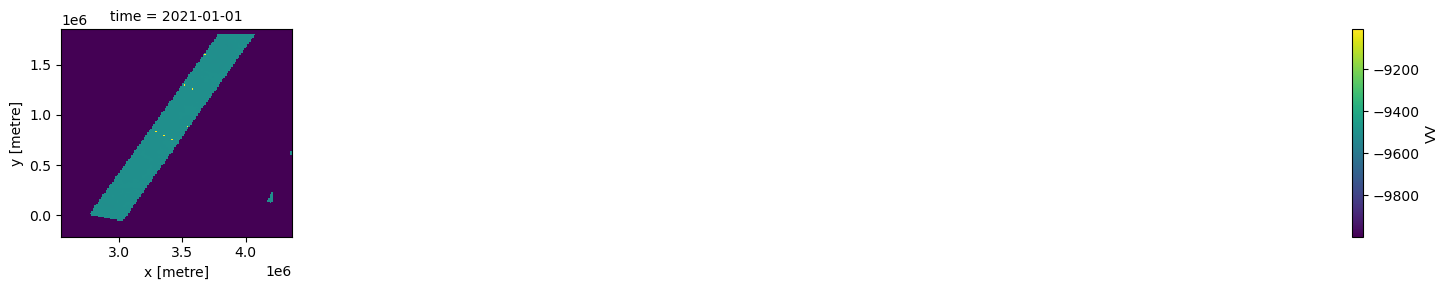

In [26]:
sig0_dc_for_plotting_daily.VV.plot.imshow(col="time", col_wrap=5)

KeyboardInterrupt: 

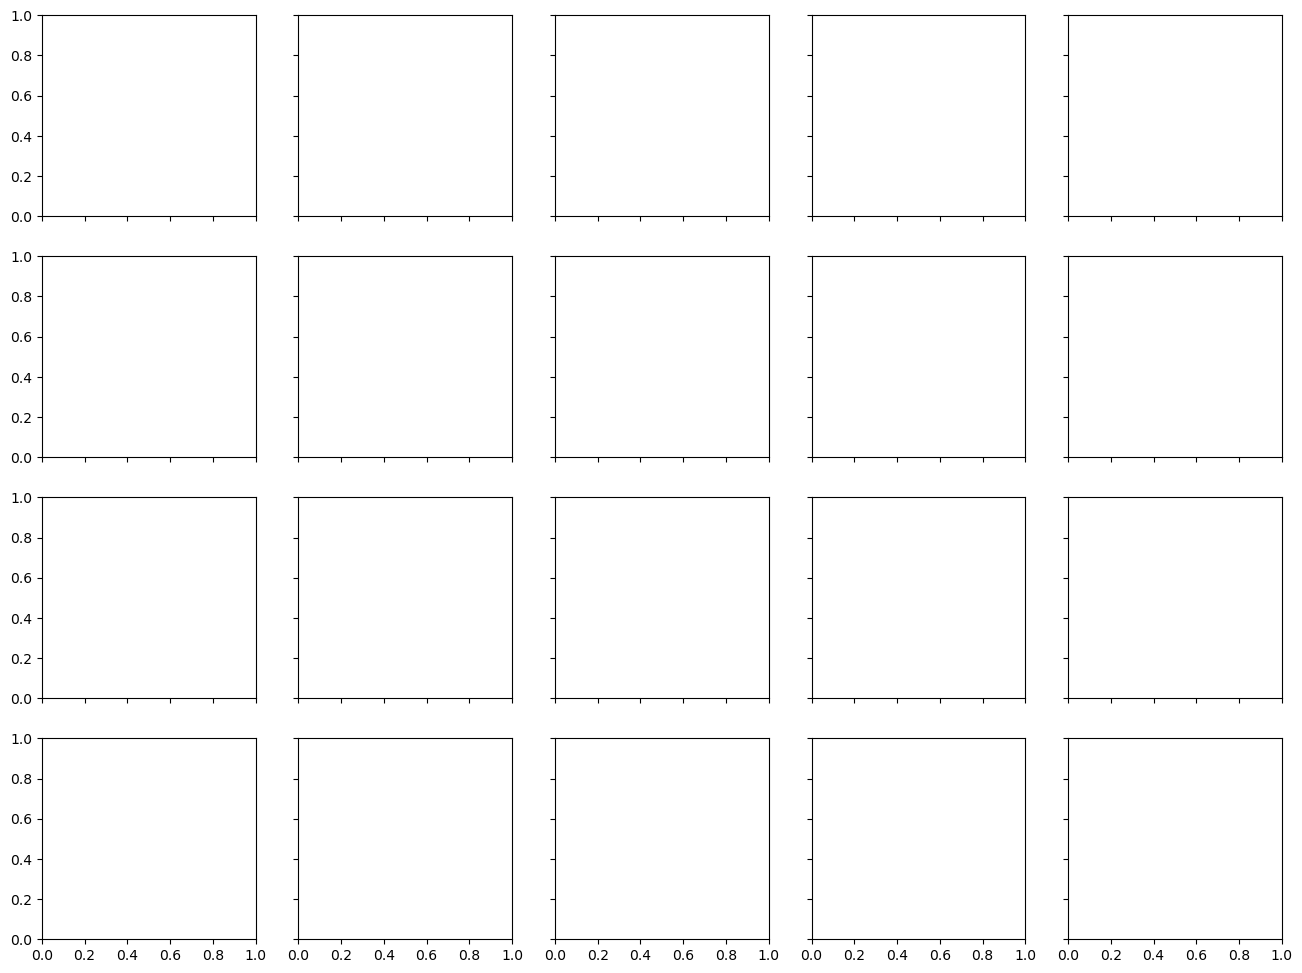

Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E033N009T3/SIG0_20210101T061726__VV_D081_E033N009T3_EU020M_V1M1R1_S1BIWGRDH_TUWIEN.tif:1
Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_AF020M/E027N084T3/SIG0_20210101T061956__VV_D081_E027N084T3_AF020M_V1M1R1_S1BIWGRDH_TUWIEN.tif:1
Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E030N006T3/SIG0_20210101T061816__VV_D081_E030N006T3_EU020M_V1M1R1_S1BIWGRDH_TUWIEN.tif:1
Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E030N006T3/SIG0_20210101T061841__VV_D081_E030N006T3_EU020M_V1M1R1_S1BIWGRDH_TUWIEN.tif:1
Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E030N006T3/SIG0_20210101T061906__VV_D081_E030N006T3_EU020M_V1M1R

In [ ]:
sig0_dc.sel(time=slice("2021-01-01","2021-01-01T12:00:00")).VV.plot.imshow(col="time", col_wrap=5)

MemoryError: Unable to allocate 17.1 GiB for an array with shape (1, 102638, 89514) and data type int16

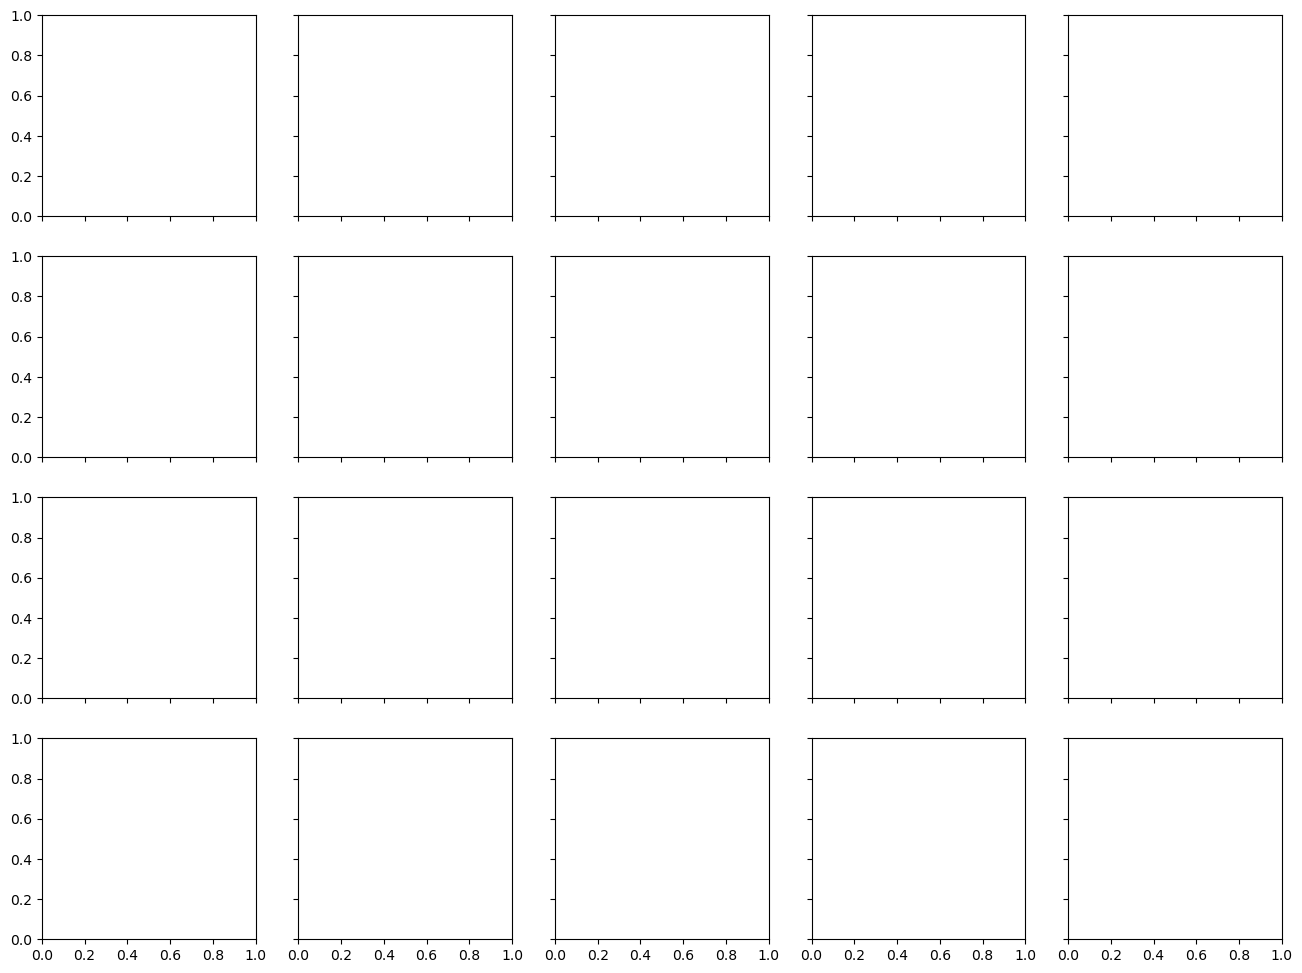

In [ ]:
sig0_dc.sel(time=slice("2021-01-01","2021-01-01T12:00:00")).isel(x=slice(0,5000), y=slice(0,5000)).VV.plot.imshow(col="time", col_wrap=5)

In [ ]:
lin2db(db2lin(sig0_dc).resample(x=500, y=500, time="1H").mean())

<xarray.Dataset> Size: 14TB
Dimensions:      (y: 102638, x: 89514, time: 192)
Coordinates:
  * y            (y) float64 821kB 1.844e+06 1.844e+06 ... -2.09e+05 -2.09e+05
  * x            (x) float64 716kB 2.56e+06 2.56e+06 ... 4.35e+06 4.35e+06
    spatial_ref  int32 4B 27704
  * time         (time) datetime64[ns] 2kB 2021-01-01T05:28:32 ... 2021-01-05...
Data variables:
    VH           (time, y, x) float32 7TB dask.array<chunksize=(1, 102638, 89514), meta=np.ndarray>
    VV           (time, y, x) float32 7TB dask.array<chunksize=(1, 102638, 89514), meta=np.ndarray>

In [ ]:
item = items_eodc[-1]
scale = item.assets["VV"].extra_fields.get("raster:bands")[0]["scale"]
nodata = item.assets["VV"].extra_fields.get("raster:bands")[0]["nodata"]
sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale

sig0_dc = sig0_dc.dropna(dim="time", how="all", subset=["VV"])  # .compute()
sig0_dc

MemoryError: Unable to allocate 17.1 GiB for an array with shape (1, 102638, 89514) and data type int16

Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E039N009T3/SIG0_20210105T054417__VV_D139_E039N009T3_EU020M_V1M1R1_S1BIWGRDH_TUWIEN.tif:1
c:\Users\jwagner\AppData\Local\anaconda3\envs\ascat-s1-synergy\lib\site-packages\rasterio\warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


KeyboardInterrupt: 

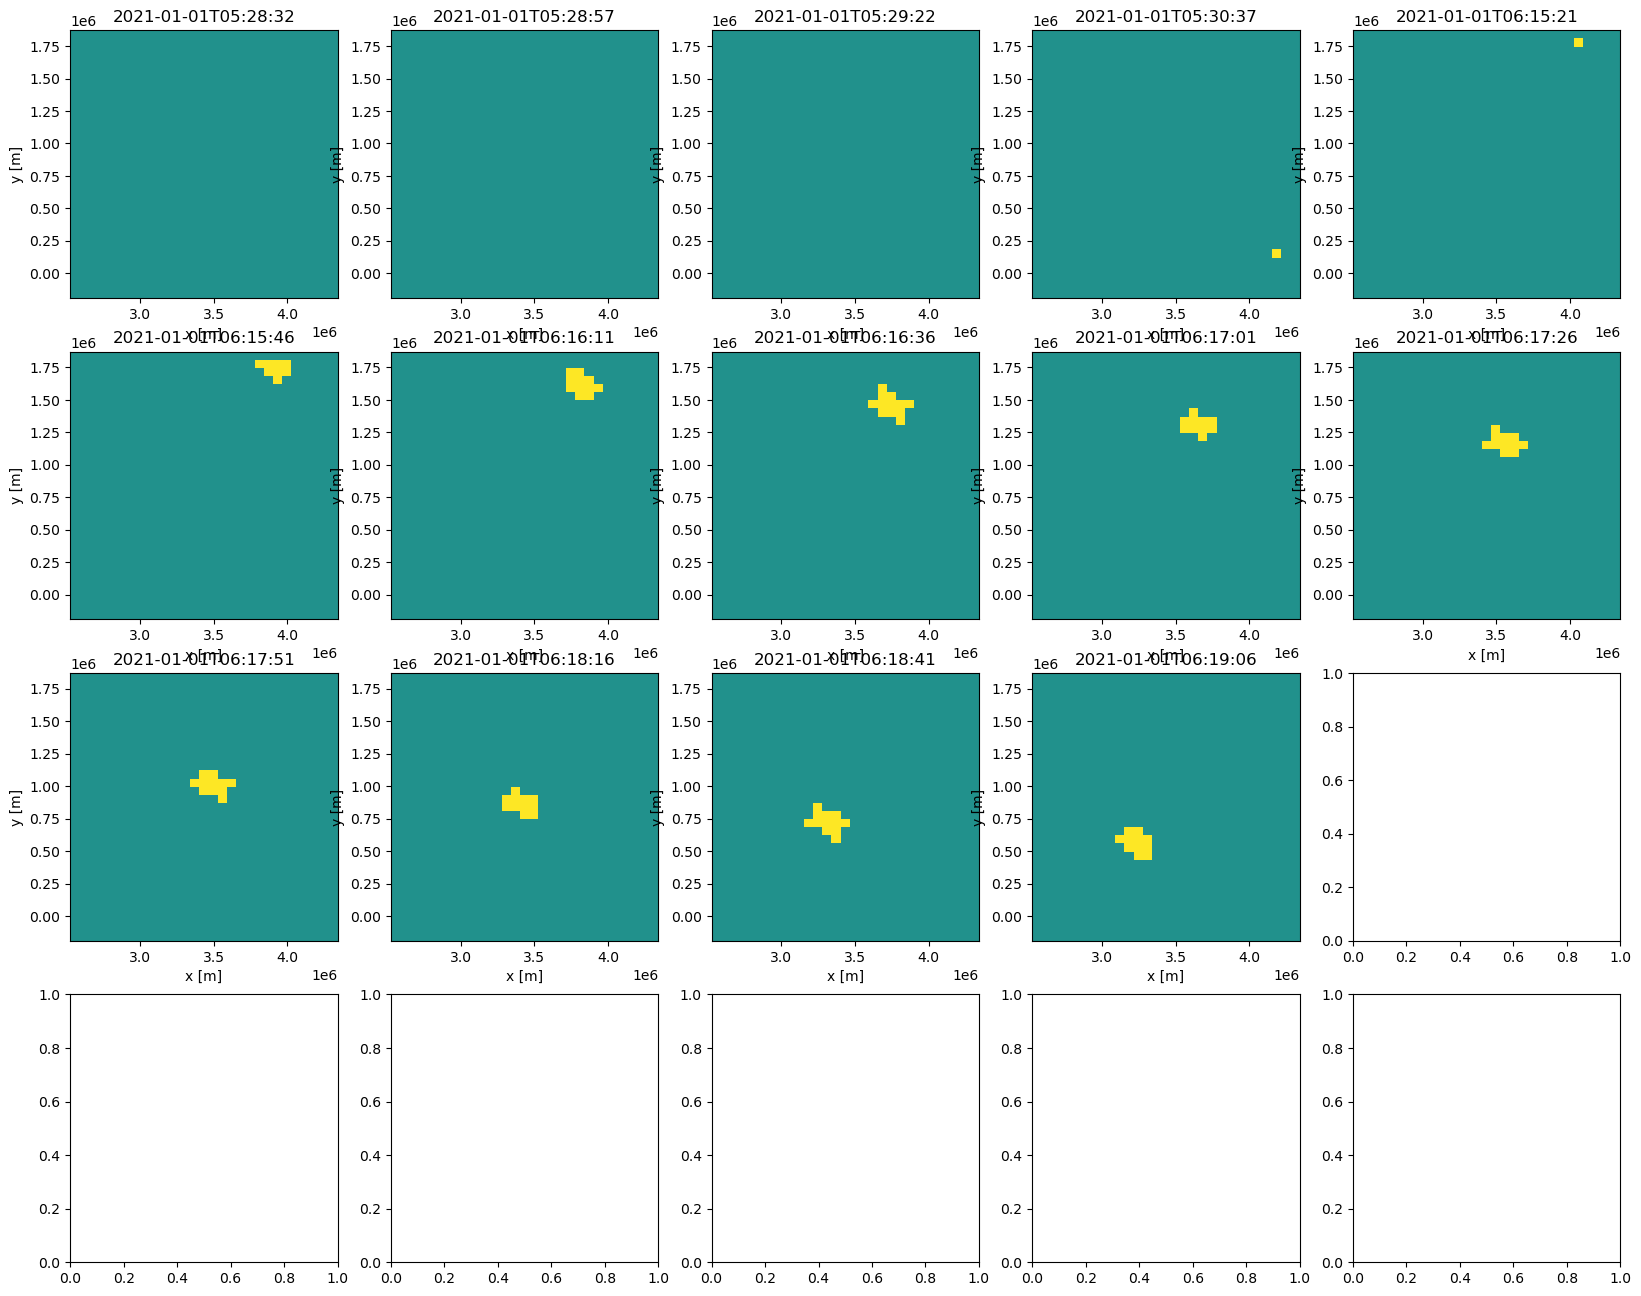

Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E036N012T3/SIG0_20210101T061636__VV_D081_E036N012T3_EU020M_V1M1R1_S1BIWGRDH_TUWIEN.tif:1
Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_AF020M/E027N087T3/SIG0_20210101T061931__VH_D081_E027N087T3_AF020M_V1M1R1_S1BIWGRDH_TUWIEN.tif:1
Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E030N006T3/SIG0_20210101T061841__VH_D081_E030N006T3_EU020M_V1M1R1_S1BIWGRDH_TUWIEN.tif:1
Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_AF020M/E030N087T3/SIG0_20210101T061956__VH_D081_E030N087T3_AF020M_V1M1R1_S1BIWGRDH_TUWIEN.tif:1
Aborting load due to failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_AF020M/E027N084T3/SIG0_20210101T062046__VH_D081_E027N084T3_AF020M_V1M1R

In [ ]:
n = 20

ds_vv = (
    sig0_dc["VV"]
    .isel(x=slice(None, None, 10), y=slice(None, None, 10))
    .isel(time=slice(0, n))
)

ncols = 5
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

axes = axes.flatten()

for i in range(n):
    vv_t = ds_vv.isel(time=i)
    ax = axes[i]
    im = vv_t.plot(ax=ax, robust=True, cmap="viridis", add_colorbar=False)
    ax.set_title(str(vv_t["time"].values)[:19])  # Shorten timestamp
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="VV [dB]")

plt.suptitle("Sentinel-1 VV (Downsampled) - First 20 Time Steps", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


EODC has items that do not overlap and are about 25 seconds apart, as that is Sentinel-1 radar acquisition time.

In [ ]:
vv_t0 = sig0_dc.VV.isel(time=4)
vv_t1 = sig0_dc.VV.isel(time=5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

vv_t0.plot(ax=axes[0], robust=True, cmap="viridis")
axes[0].set_title(f"Sentinel-1 VV - Time 0\n{str(vv_t0.time.values)}")

vv_t1.plot(ax=axes[1], robust=True, cmap="viridis")
axes[1].set_title(f"Sentinel-1 VV - Time 1\n{str(vv_t1.time.values)}")

plt.tight_layout()
plt.show()

So to avoid having double the amount of data per time instance, lets merge EODC items per hour. We can also merge per minute, or even day, since for this area we have data every ~4 days, so that is the rough temporal resolution. But let's keep it precision in the hourly range.

In [ ]:
# sig0_dc2 = sig0_dc.resample(time="d").first()

In [ ]:
hourly_time = sig0_dc.time.dt.floor("h")
sig0_dc = sig0_dc.assign_coords(hourly_time=("time", hourly_time.data))
sig0_dc = sig0_dc.groupby("hourly_time").mean(dim="time")
sig0_dc = sig0_dc.rename({"hourly_time": "time"})

sig0_dc

In [ ]:
n = 20

ds_vv = (
    sig0_dc["VV"]
    .isel(x=slice(None, None, 10), y=slice(None, None, 10))
    .isel(time=slice(0, n))
)

ncols = 5
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 4 * nrows))

axes = axes.flatten()

for i in range(n):
    vv_t = ds_vv.isel(time=i)
    ax = axes[i]
    im = vv_t.plot(ax=ax, robust=True, cmap="viridis", add_colorbar=False)
    ax.set_title(str(vv_t["time"].values)[:19])  # Shorten timestamp
    ax.set_xlabel("x [m]")
    ax.set_ylabel("y [m]")


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, label="VV [dB]")

plt.suptitle("Sentinel-1 VV (Downsampled) - First 20 Time Steps", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


We see that we have half of the time instances now. So let's plot first merged item (radar image) to see were images (that were acquired on the same day and in same hour) on the previous plot merged.

In [ ]:
sig0_dc.isel(time=0).VV.plot(size=8, robust=True)

Lets export the datacube as a zar file

In [ ]:
sig0_dc

In [ ]:
sig0_dc.to_zarr(r"C:\Users\jwagner\Desktop\ascat-sentinel-1-synergy\zarr-file.zarr")

In [ ]:
data_path = Path(r"C:\Users\jwagner\Desktop\ascat-sentinel-1-synergy\zarr-file.zarr").\
    expanduser()
fused_ds = xr.open_dataset(data_path, decode_coords="all", engine="zarr")

In [ ]:
fused_ds